In [75]:
from ISLP import load_data
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from ISLP.models import (summarize, poly, ModelSpec as MS)
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

In [84]:
df = load_data("College")
df['Private'] = df.Private.map(dict(Yes=1,No=0))
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [19]:
# Forward Selection
# We're going to choose the next best model based on C_p
# By default sklearn tries to max a score, so we get neg C_p
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    # Formula for C_p
    return -(RSS + 2 * p * sigma2) / n

In [48]:
# We need to estimate sigma^2
# Fit the biggest model with all p and use MSE as sigma^2
design = MS(df.columns.drop('Outstate')).fit(df)
Y = np.array(df['Outstate'])
#np.asarray(Y)
X = design.transform(df)

sigma2 = OLS(Y,X).fit().scale

In [49]:
# The function sklearn_selected() expects a function with three args
# So we freeze sigma2
neg_Cp = partial(nCp, sigma2)

In [62]:
# Fitting with forward selecting using neg_CP as scoring
college_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
college_Cp.fit(df,Y)
preds = list(college_Cp.selected_state_)
preds

['Accept',
 'Apps',
 'Enroll',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Personal',
 'PhD',
 'Private',
 'Room.Board',
 'S.F.Ratio',
 'Terminal',
 'Top10perc',
 'perc.alumni']

In [118]:
# Generalized Additive Models GAMs

# s for smoothing spline, l for linear, f for factor/categorical vars
X_ = np.asarray(df[preds]) 
gam = LinearGAM(s_gam(0,lam=0.6)) # We pass in 0 to indicate the smoother will apply to the first column
gam.fit(X_, Y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

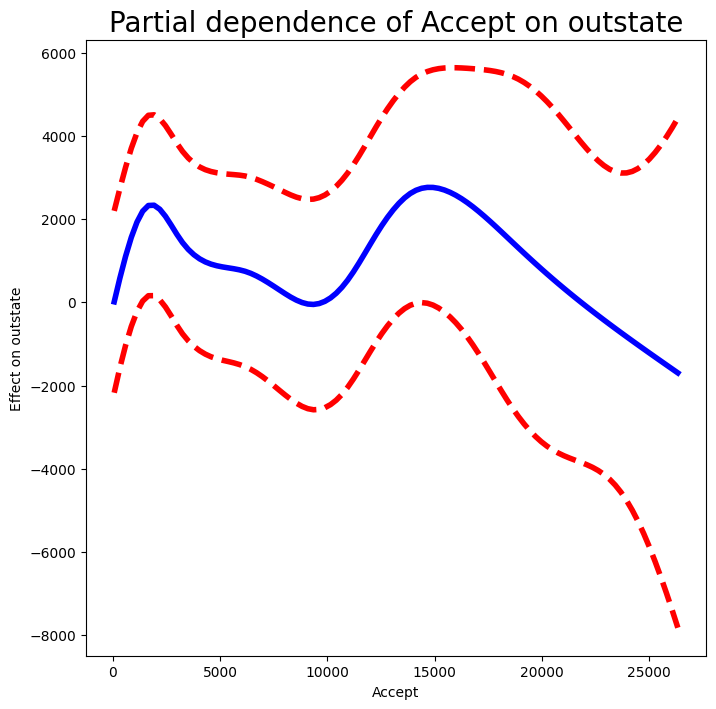

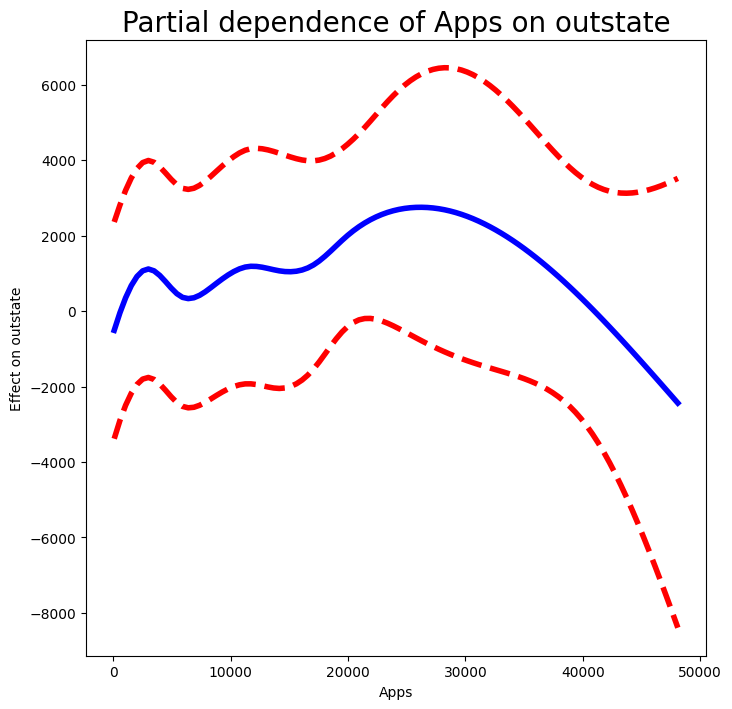

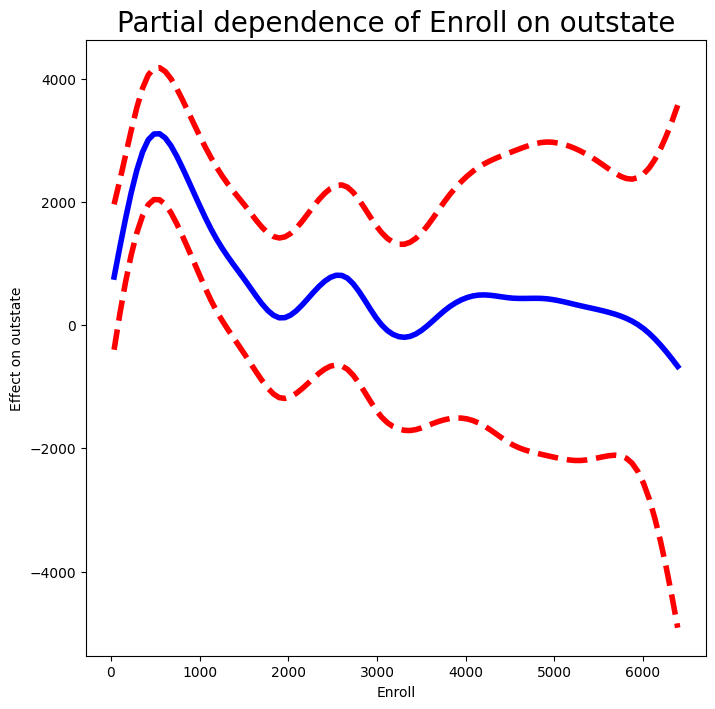

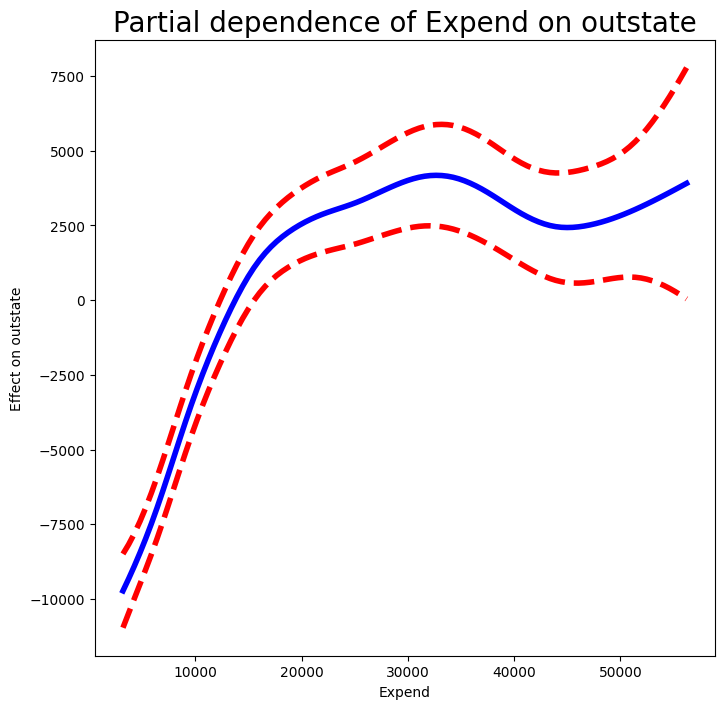

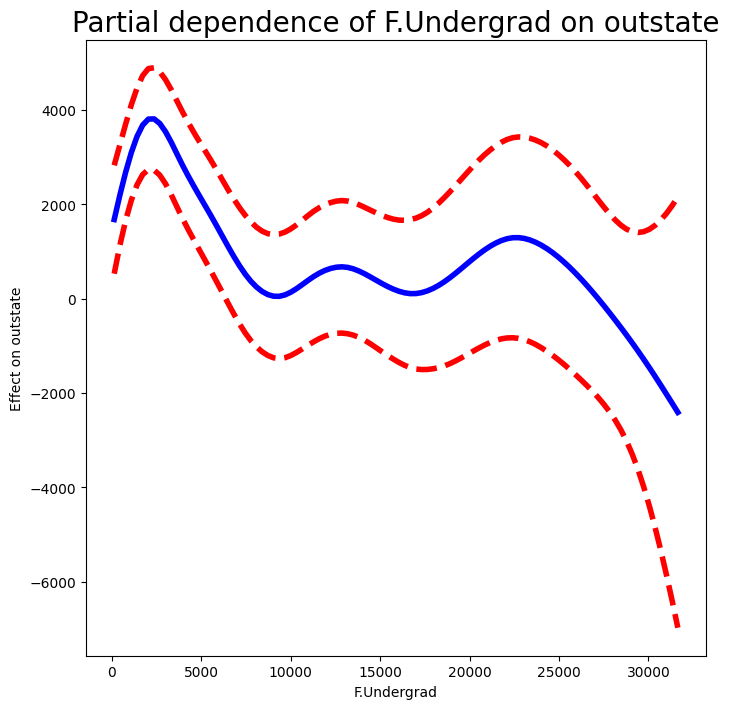

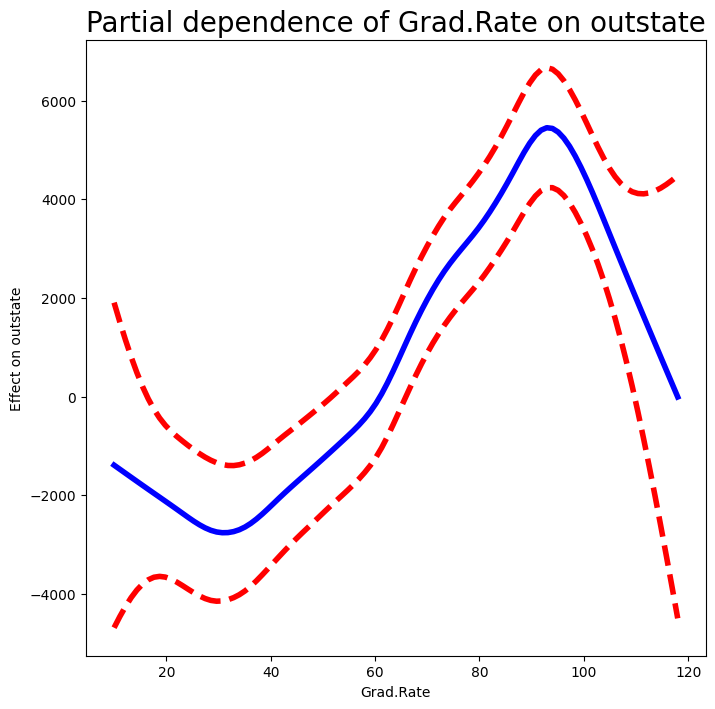

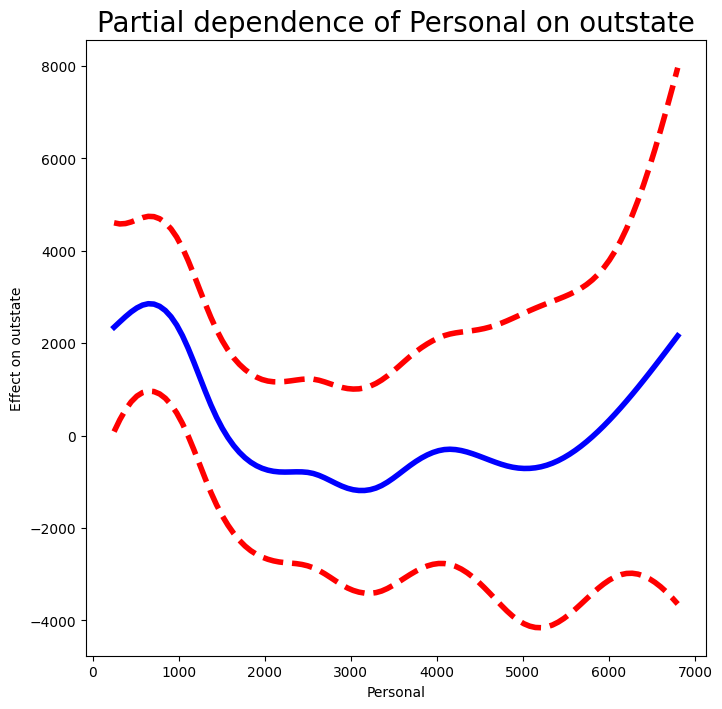

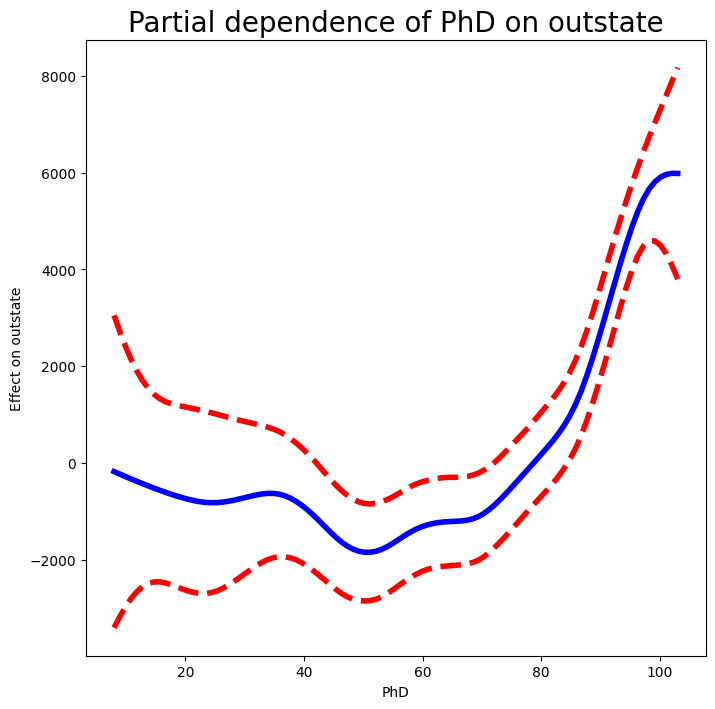

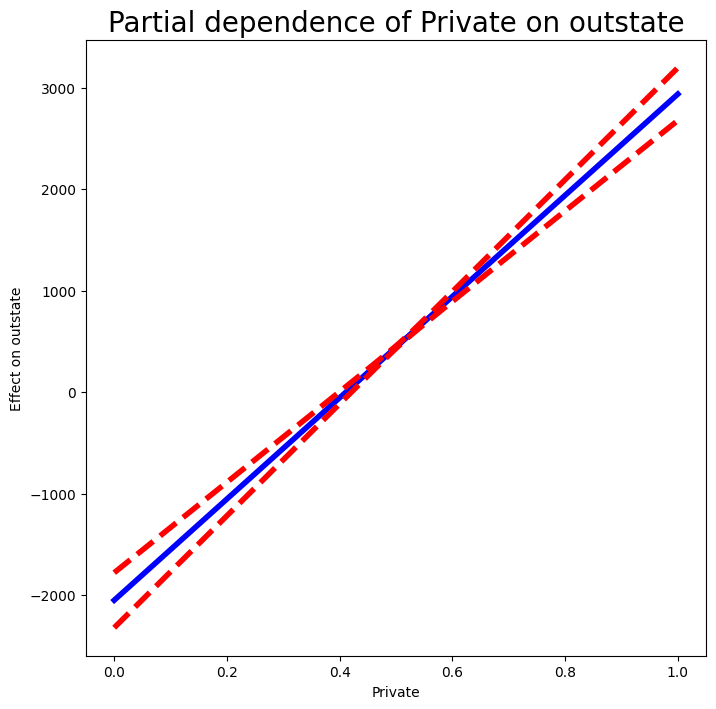

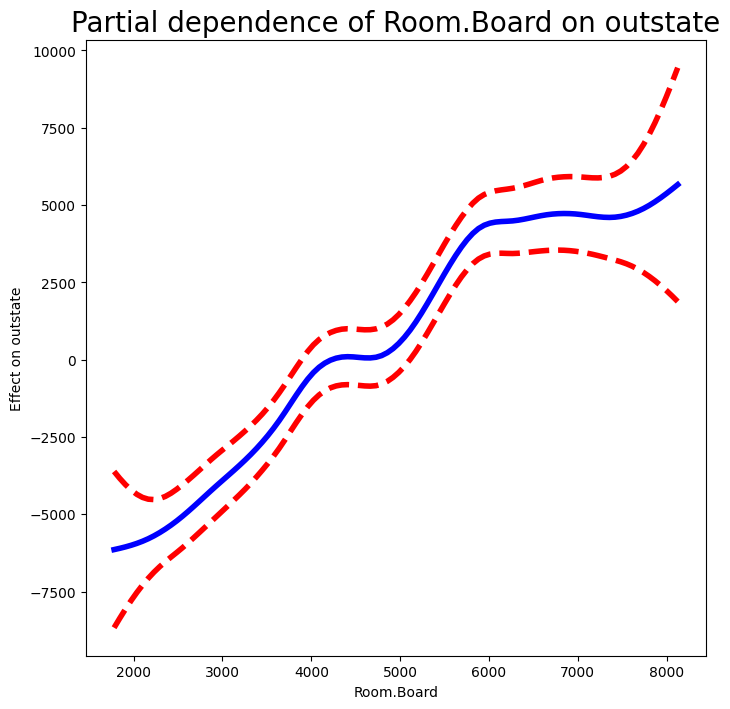

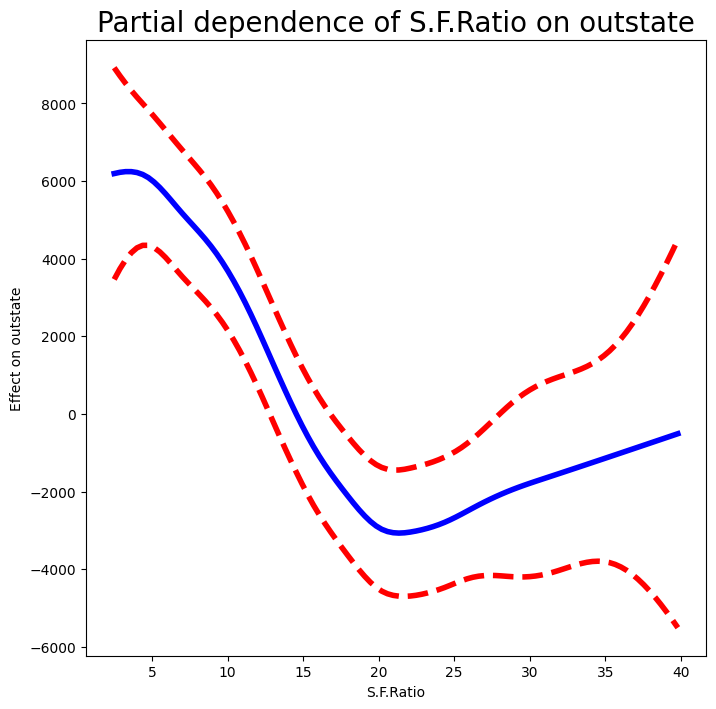

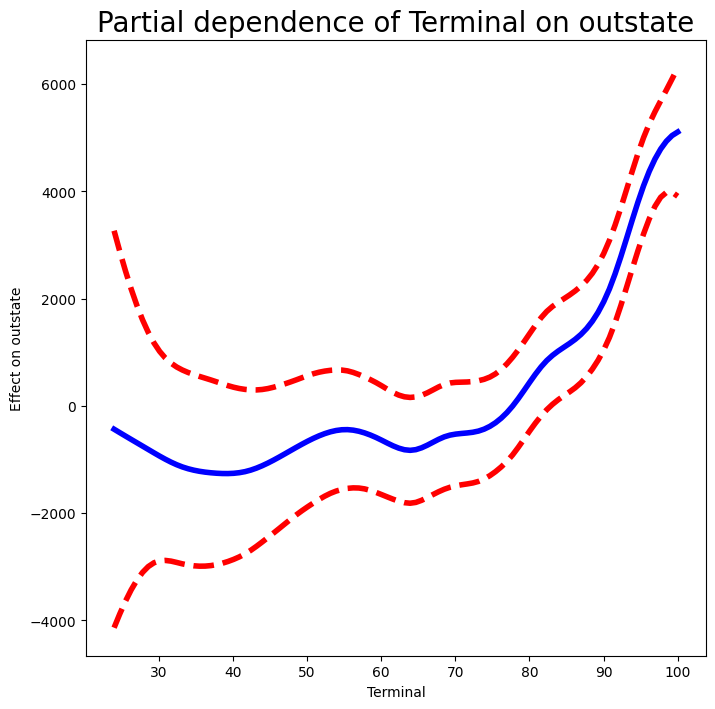

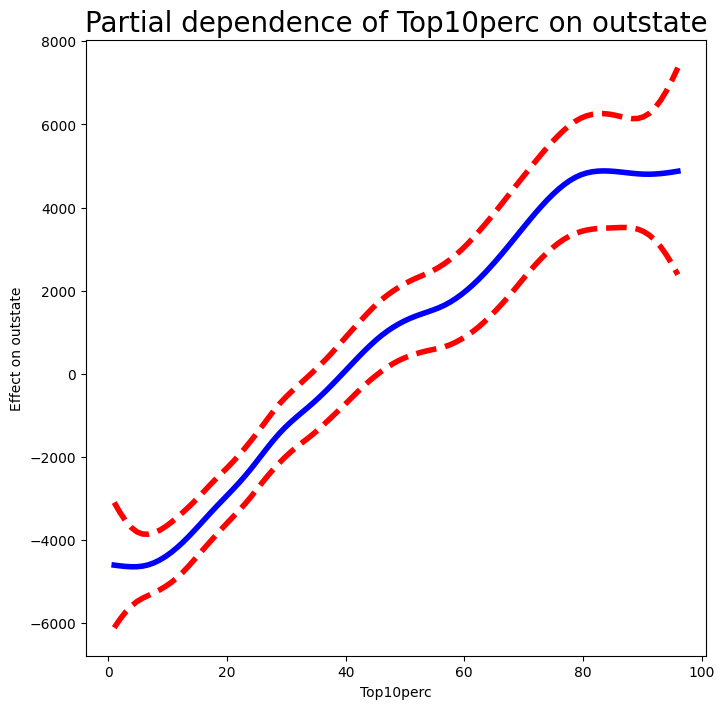

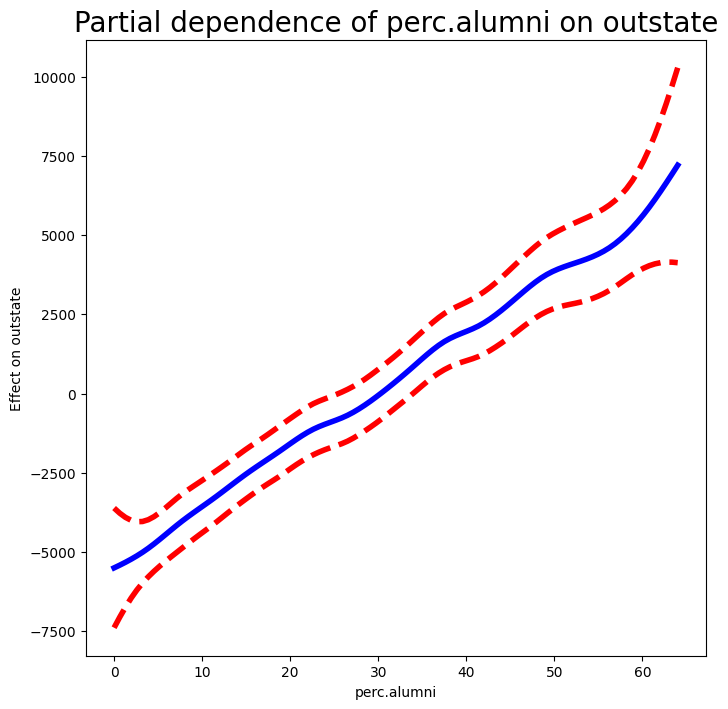

In [124]:
# Plotting using ISLP library
for pred in preds:
    gam = LinearGAM(s_gam(preds.index(pred),lam=3))
    gam.fit(X_,Y)
    fig, ax = subplots(figsize=(8,8))
    plot_gam(gam,0, ax=ax)
    ax.set_xlabel(pred)
    ax.set_ylabel('Effect on outstate')
    ax.set_title('Partial dependence of ' + pred+ ' on outstate', fontsize=20);